In [ ]:
!nvidia-smi

In [2]:
# using gpu:/0
import tensorflow as tf
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    tf.config.experimental.set_memory_growth(gpus[0], True)
  except RuntimeError as e:
    print(e)

In [3]:
print(gpus)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [19]:
#from tensorflow.python.client import device_lib
#print(device_lib.list_local_devices())

In [8]:
import tensorflow as tf
tf.config.experimental.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:2', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:3', device_type='GPU')]

## Dataset 분할

---

`Train` : `Test` = 0.75 : 0.25

- test

0-19 = 100명<br>
20-49 = 75명<br>
50- = 51명<br>

= 226 * 4 = 804개의 image

- train


0-19 = 299명

20-49 = 225명

50- = 154명

= 678 * 4 = 2712개의 image

In [3]:
import os
path_dir1 = '../sungjin/tooth3/train/'
path_dir2 = '../sungjin/tooth3/test/'

sub_directory = ['under20/','under50/','over50/']

TRAIN_NUM = 0
TEST_NUM = 0

for subdir in sub_directory:
    tmp_list = os.listdir(path_dir1+subdir)
    TRAIN_NUM += len(tmp_list)
    
for subdir in sub_directory:
    tmp2_list = os.listdir(path_dir2+subdir)
    TEST_NUM += len(tmp2_list)
    

In [4]:
# the number of training data = 2812
print(TRAIN_NUM)

2812


In [5]:
# the number of test data = 804
print(TEST_NUM)

804


In [19]:
import numpy as np

# preprocessing image

train_img = np.float32(np.zeros((TRAIN_NUM,151,112,3)))
train_label = np.uint8(np.zeros((TRAIN_NUM,)))

test_img = np.float32(np.zeros((TEST_NUM,151,112,3)))
test_label = np.uint8(np.zeros((TEST_NUM,)))

## Make Label

---

ImageDataGenerator는 directory별로 data augmentation

--> 두가지 네트워크를 비교했을 때 둘다 prediction에서 문제가 생김

따라서, 라벨링을 통해 다시한번 실험중

In [20]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications.resnet50 import preprocess_input

make_label = [0,1,2]

num = 0
idx = 0
for subdir in sub_directory:
    give_label = make_label[idx]
    for file in os.listdir(path_dir1+subdir):
        src_path = path_dir1 + subdir + file
        img = load_img(src_path, target_size = (151,112))

        x = img_to_array(img)
        x = np.expand_dims(x, axis=0)
        x = preprocess_input(x)
        
        train_img[num, :, :, :] = x

        train_label[num] = give_label
        num = num + 1
    idx += 1

In [21]:
num = 0
idx = 0

for subdir in sub_directory:
    give_label = make_label[idx]
    for file in os.listdir(path_dir2+subdir):
        src_path = path_dir2 + subdir + file
        img = load_img(src_path, target_size = (151,112))

        x = img_to_array(img)
        x = np.expand_dims(x, axis=0)
        x = preprocess_input(x)
        
        test_img[num, :, :, :] = x

        test_label[num] = give_label
        num = num + 1
    idx += 1

In [27]:
import keras

train_label = keras.utils.to_categorical(train_label,3)
test_label = keras.utils.to_categorical(test_label,3)

## Data Augmentation

In [31]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
# create a data generator

datagen = ImageDataGenerator(
        #rescale=1./255, rescale시에 데이터가 모두 0에 근접
        #zoom_range = 0.2,
        rotation_range=25,  # randomly rotate images in the range (degrees, 0 to 180)
        horizontal_flip=True,  # randomly flip images left and right
        vertical_flip=True)  # randomly flip images upside down

In [46]:
# # load and iterate training dataset

seed = 1
    
# train_it = datagen.flow_from_directory('../sungjin/tooth3/train/',
# #                                        save_to_dir='../sungjin/dog2/train/', //2700여개의 파일이 생성됨
#                                        seed = seed,
#                                        target_size=(151,112), 
#                                        color_mode='rgb', 
#                                        class_mode='categorical', 
#                                        batch_size=32)
# # load and iterate test dataset
test_it = datagen.flow_from_directory('../sungjin/tooth3/test/', 
#                                       save_to_dir='../sungjin/dog2/test/', // 1600여개의 파일이 생성됨
                                      seed = seed,
                                      target_size=(151,112), 
                                      color_mode='rgb', 
                                      class_mode='categorical', 
                                      batch_size=32)

Found 804 images belonging to 3 classes.


## Transfer Learning

In [32]:
import tensorflow as tf
from keras import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,AveragePooling2D,Flatten,Dropout
from tensorflow import keras

base_model = keras.applications.ResNet152(
    include_top=False,
    weights="imagenet",
    input_shape=(151,112,3)
)

In [13]:
# base_model.trainable = False

### Classification 층만 삭제하고 GAP

<p align = 'center'><img src = "https://img1.daumcdn.net/thumb/R1280x0/?scode=mtistory2&fname=https%3A%2F%2Fblog.kakaocdn.net%2Fdn%2FcbiE7o%2FbtqBAWPPArB%2FcRcHO5YpJaPVbDEyl0tsPK%2Fimg.png", width = "400px"></p>

CNN -> Flatten : parameter 증가, overfitting 증가, 공간정보 잃을가능성

CNN -> GAP : 공간정보 유지 증가

In [33]:
from tensorflow.keras.layers import GlobalAveragePooling2D

model = Sequential()

model.add(base_model)
model.add(GlobalAveragePooling2D())
model.add(Dense(3,activation = 'softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet152 (Model)            (None, 5, 4, 2048)        58370944  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 3)                 6147      
Total params: 58,377,091
Trainable params: 58,225,667
Non-trainable params: 151,424
_________________________________________________________________


In [34]:
model.compile(optimizer = keras.optimizers.Adam(lr = 0.00001),
              loss = 'categorical_crossentropy',
              metrics = ['accuracy'])

In [35]:
history = model.fit(datagen.flow(train_img,train_label,batch_size=32),
                    validation_data=datagen.flow(test_img,test_label,batch_size =32),
                    batch_size = 32,
                    epochs=20)
model.save("GAP0210-2.h5")

Epoch 1/20
88/88 [==============================] - 28s 322ms/step - loss: 0.9777 - accuracy: 0.5277 - val_loss: 1.0067 - val_accuracy: 0.5535
Epoch 2/20
88/88 [==============================] - 23s 262ms/step - loss: 0.6275 - accuracy: 0.7265 - val_loss: 0.8454 - val_accuracy: 0.6219
Epoch 3/20
88/88 [==============================] - 23s 265ms/step - loss: 0.5292 - accuracy: 0.7628 - val_loss: 0.7686 - val_accuracy: 0.6580
Epoch 4/20
88/88 [==============================] - 23s 261ms/step - loss: 0.4575 - accuracy: 0.7973 - val_loss: 0.7389 - val_accuracy: 0.6592
Epoch 5/20
88/88 [==============================] - 23s 256ms/step - loss: 0.4328 - accuracy: 0.8115 - val_loss: 0.6716 - val_accuracy: 0.7065
Epoch 6/20
88/88 [==============================] - 23s 265ms/step - loss: 0.4094 - accuracy: 0.8304 - val_loss: 0.7091 - val_accuracy: 0.7052
Epoch 7/20
88/88 [==============================] - 23s 257ms/step - loss: 0.3757 - accuracy: 0.8482 - val_loss: 0.5791 - val_accuracy: 0.7313

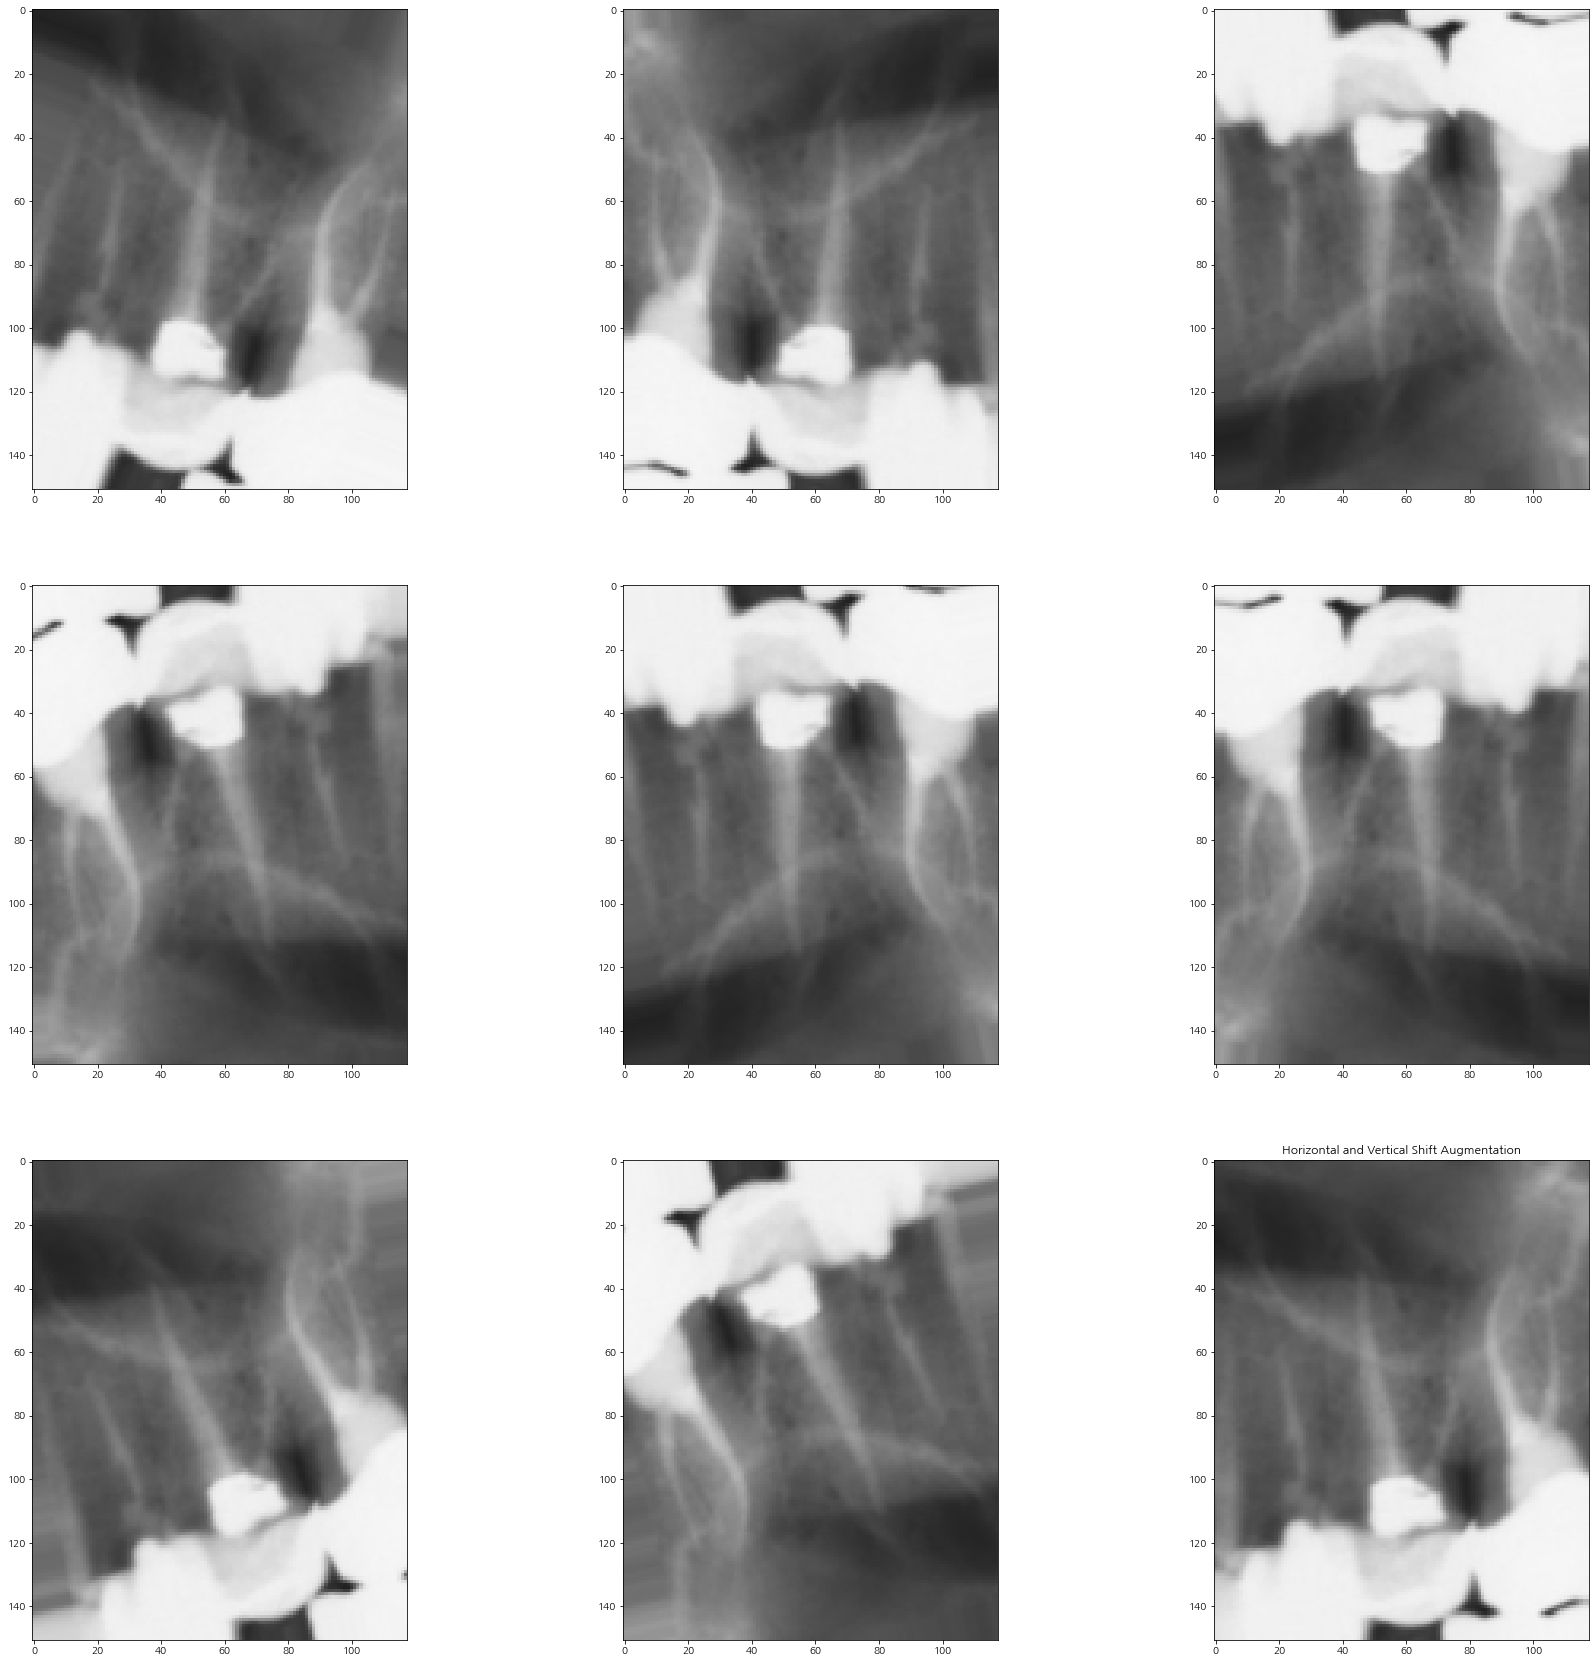

In [22]:
import matplotlib.pyplot as plt
# 첫 번째 차원을 추가하여 확장
img = load_img('../sungjin/tooth3/test/under50/20683982 기선미 16.png')
data = img_to_array(img)
samples = np.expand_dims(data, 0)
datagen = ImageDataGenerator(
        rotation_range=30, # randomly rotate images in the range (degrees, 0 to 180)
        horizontal_flip=True,  # randomly flip images left and right
        vertical_flip=True)
datagen.fit(train_img)
datagen.fit(test_img)


it = datagen.flow(samples, batch_size=32)

fig = plt.figure(figsize = (30,30))

# 9개 이미지 생성
for i in range(9):
    plt.subplot(3, 3, i+1)
    batch = it.next()
    image = batch[0].astype('uint8')
    plt.imshow(image)

# show the figure
plt.title("Horizontal and Vertical Shift Augmentation")
plt.show()

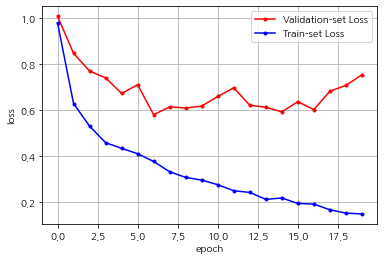

In [36]:
import numpy as np
import matplotlib.pyplot as plt

y_vloss = history.history['val_loss']
y_loss = history.history['loss']

x_len = np.arange(len(y_loss))


plt.plot(x_len, y_vloss, marker='.', c='red', label="Validation-set Loss")
plt.plot(x_len, y_loss, marker='.', c='blue', label="Train-set Loss")

plt.legend(loc='upper right')
plt.grid()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

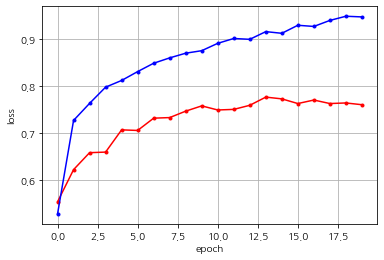

In [37]:
y_vacc = history.history['val_accuracy']
y_acc = history.history['accuracy']

x_len = np.arange(len(y_acc))

plt.plot(x_len, y_vacc, marker='.', c='red')
plt.plot(x_len, y_acc, marker='.', c='blue')

plt.grid()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

## Predict 

In [52]:
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from tensorflow.keras.preprocessing import image as image_utils
from tensorflow.keras.applications.imagenet_utils import preprocess_input

In [70]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import numpy as np
path = '../sungjin/tooth3/test/'
path2 = '../sungjin/tooth3/test/'
subdir = ['under20/','under50/','over50/']
num = 0

for sub in subdir:
    num = 0
    print("--------------[predict]-------------")
    for file in os.listdir(path+sub):
        src_path = path + sub+file
        img = load_img(src_path, target_size = (151,112))

        x = img_to_array(img)
        x = x.reshape(1,151,112,3)
        x = preprocess_input(x)
        preds = model.predict(x)
        
        print(np.argmax(preds), end = ' ')
        num = num + 1
        
        if num == 30:
            break
    print(" ")
    


--------------[predict]-------------
0 0 0 1 0 0 1 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0  
--------------[predict]-------------
2 1 1 1 1 1 0 0 0 1 1 1 0 1 1 1 1 0 1 1 1 1 0 1 1 1 1 1 2 0  
--------------[predict]-------------
2 1 0 2 1 2 1 2 2 1 1 2 1 2 2 1 1 2 2 2 2 2 2 2 2 1 2 2 2 2  


array([[0.05721931, 0.24046464, 0.70231605]], dtype=float32)

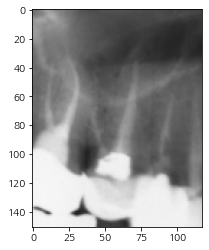

In [57]:
def show_image(image_path):
    image = mpimg.imread(image_path)
    plt.imshow(image)

def make_predictions(image_path):
    show_image(image_path)
    image = image_utils.load_img(image_path, target_size=(151, 112))
    image = image_utils.img_to_array(image)
    image = image.reshape(1,151,112,3)
    image = preprocess_input(image)
    preds = model.predict(image)
    
    return preds
make_predictions('../sungjin/tooth3/test/under50/20683982 기선미 16.png')

In [58]:
def predict_agegroup(image_path):
    preds = make_predictions(image_path)
    preds = np.argmax(preds)
    if preds == 0:
        print("나이는 0~19세 사이일 것입니다.")
    elif preds == 1:
        print("나이는 20~49세 사이일 것입니다.")
    else:
        print("나이는 50세 이상일 것입니다.")

나이는 50세 이상일 것입니다.


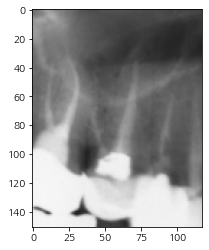

In [59]:
predict_agegroup('../sungjin/tooth3/test/under50/20683982 기선미 16.png')

나이는 20~49세 사이일 것입니다.


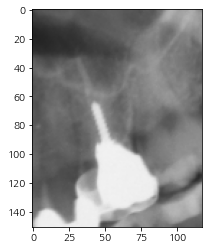

In [60]:
predict_agegroup('../sungjin/tooth3/test/under50/20683982 기선미 26.png')

나이는 20~49세 사이일 것입니다.


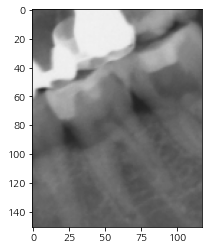

In [62]:
predict_agegroup('../sungjin/tooth3/test/under50/20683982 기선미 36.png')

나이는 20~49세 사이일 것입니다.


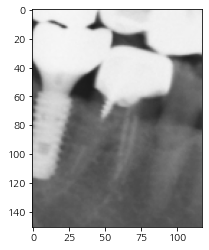

In [63]:
predict_agegroup('../sungjin/tooth3/test/under50/20683982 기선미 46.png')

나이는 50세 이상일 것입니다.


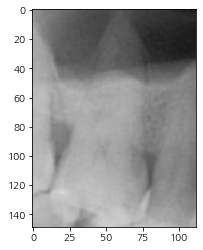

In [64]:
predict_agegroup('../sungjin/tooth3/test/over50/20683260 엄대용 16.png')

나이는 0~19세 사이일 것입니다.


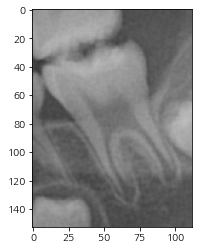

In [66]:
predict_agegroup('../sungjin/tooth3/test/under20/20681129 지민찬 36.png')

## ROC-AUC

In [71]:
import IPython
app = IPython.Application.instance()
app.kernel.do_shutdown(True)

{'status': 'ok', 'restart': True}